# Pytorch-Lightning

In [234]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

import numpy as np
import matplotlib.pyplot as plt
import time

## 1. Define Model

### 1.1 pytorch_lightning.LightningModule

- [LIGHTNING MODULE](<https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html#lightningmodule>)
- Required Methods
    - **forward()**: defines the prediction/inference actions.
    - **training_step()**: defined the train loop. Independent of forward.
    - **configure_optimizers()**: define optimizer.
- To validate and test the model, define below methods
    - **validation_step()**
    - **test_step()**

In [235]:
# Default
class AutoEncoder(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 28*28)
        )

    def forward(self, x):
        z = self.encoder(x)
        y_hat = self.decoder(z)
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log('train/loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # validation_step is not required. it is for log.
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log('valid/loss', loss)
        return loss, x, x_hat, z, y

    def test_step(self, batch, batch_idx):
        # test_step is not required. it is for log.
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log('test/loss', loss)
        return loss, x, x_hat, z, y

    def training_epoch_end(self, train_step_outputs):
        loss = round(np.sum([ val["loss"].numpy() for val in train_step_outputs ]), 4)
        print("TRAIN | epoch: {} | loss: {}".format(self.current_epoch, loss))
    
    def validation_epoch_end(self, valid_step_outputs):
        self.draw_results(valid_step_outputs)

    def test_epoch_end(self, test_step_outputs):
        self.draw_results(test_step_outputs)

    def draw_results(self, test_step_outputs):
        # get data
        first_batch_outputs = test_step_outputs[0]
        losses, xs, x_hats, zs, ys = first_batch_outputs
        
        zs = zs.numpy()
        ys = ys.numpy()
        for i in range(1, len(test_step_outputs)):
            next_zs = test_step_outputs[i][3].numpy()
            next_ys = test_step_outputs[i][4].numpy()
            zs = np.append(zs, next_zs, axis=0)
            ys = np.append(ys, next_ys)
        
        # compare original and reconstructed images
        plt.figure(figsize=(16,4))
        for i in range(8):
    
            plt.subplot(2,8,i*2+1)
            plt.imshow(xs[i].reshape([28, 28]))
        
            plt.subplot(2,8,i*2+2)
            plt.imshow(x_hats[i].reshape([28, 28]))
            
        plt.show()
        
        # show latent spaces
        plt.figure(figsize=(12,12))
        scatter = plt.scatter(zs[:, 0], zs[:, 1], c=ys)
        plt.legend(*scatter.legend_elements(), loc="lower left", title="Numbers")
        plt.show()
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [236]:
# To use multiple optimizer

# class GAN(pl.LightningModule):

#     def __init__(self):
#         super().__init__()
#         self.automatic_optimization = False
#         ...


#     def forward(self, x):
#         ...

#     def training_step(self, batch, batch_idx):
#         opt_a, opt_b = self.optimizers(use_pl_optimizer=True)

#         loss_a = self.generator(batch)
#         opt_a.zero_grad()
        # use `manual_backward()` instead of `loss.backward` to automate half precision, etc...
#         self.manual_backward(loss_a)
#         opt_a.step()

#         loss_b = self.discriminator(batch)
#         opt_b.zero_grad()
#         self.manual_backward(loss_b)
#         opt_b.step()

#     def configure_optimizers(self):
        # It does not works when attribute automatic_optimization is false


## 2. Load Trainset

In [237]:
dataset = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())
train_set, valid_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = MNIST(os.getcwd(), transform=transforms.ToTensor(), train=False, download=True)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

## 3. Initialize and Train Model

### 3.1 pytorch_lightning.Trainer() parameters

- Machine
    - **num_processes**: number of processes for distributed training with
    - **gpus**: number of gpus to train on (int) or which GPUs to train on (list or str) applied per node
    - **num_nodes**: number of gpu nodes
- Training
    - **max_epochs**: max epochs, default 1000 
    - **min_epochs**: min epochs, default 1
    - **max_steps**: max steps, default None
    - **min_steps**: min steps, default None
- Validation
    - **val_check_interval**: Check val every n train epochs.
    - **num_sanity_val_steps**: number of sanity check trials. To use all validation sets, set it -1
- Save
    - **default_root_dir**: path for logs and checkpoints. Default `os.getcwd()`
    - **callbacks**(Union[List[Callback], Callback, None]): Add a callback or list of callbacks.
    - **checkpoint_callback**(bool): If True, enable checkpointing. It will configure a default

### 3.2 pytorch.lightning.Trainer() methods

- **fit**(model, train_dataloader=None, val_dataloaders=None, datamodule=None)
- **predict**(model=None, dataloaders=None, datamodule=None, return_predictions=None)
- **test**(model=None, test_dataloaders=None, ckpt_path='best', verbose=True, datamodule=None)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.4 K
1 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)


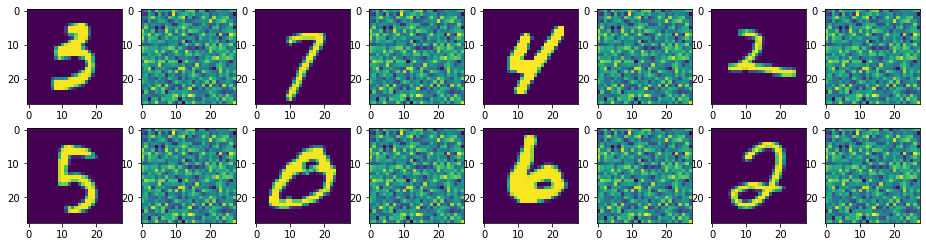

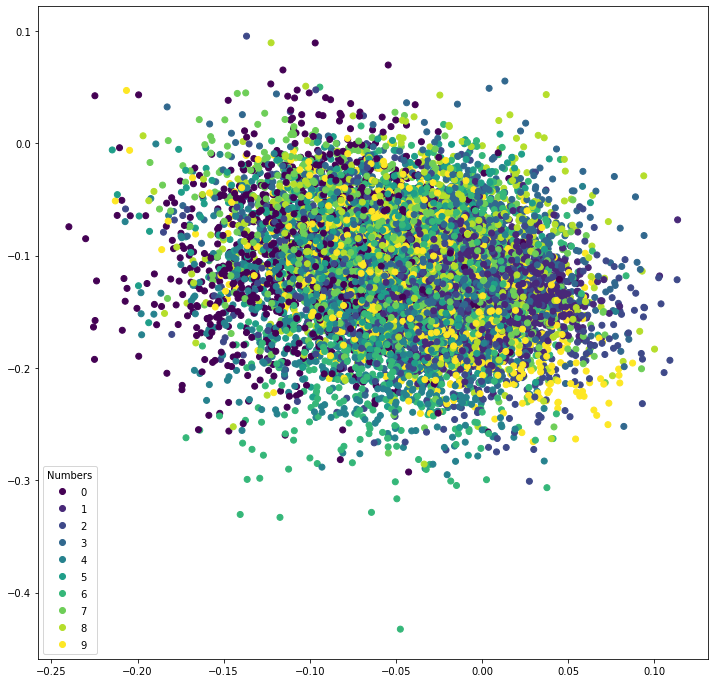

TRAIN | epoch: 0 | loss: 43.32170104980469
TRAIN | epoch: 1 | loss: 38.16270065307617
TRAIN | epoch: 2 | loss: 37.309600830078125
TRAIN | epoch: 3 | loss: 36.68130111694336
TRAIN | epoch: 4 | loss: 36.12260055541992
TRAIN | epoch: 5 | loss: 35.68550109863281
TRAIN | epoch: 6 | loss: 35.3568000793457
TRAIN | epoch: 7 | loss: 35.11220169067383
TRAIN | epoch: 8 | loss: 34.9025993347168
TRAIN | epoch: 9 | loss: 34.75310134887695
TRAIN | epoch: 10 | loss: 34.59880065917969
TRAIN | epoch: 11 | loss: 34.4723014831543
TRAIN | epoch: 12 | loss: 34.34989929199219
TRAIN | epoch: 13 | loss: 34.23270034790039
TRAIN | epoch: 14 | loss: 34.160400390625
TRAIN | epoch: 15 | loss: 34.05329895019531
TRAIN | epoch: 16 | loss: 33.96659851074219
TRAIN | epoch: 17 | loss: 33.876399993896484
TRAIN | epoch: 18 | loss: 33.80440139770508
TRAIN | epoch: 19 | loss: 33.73939895629883
TRAIN | epoch: 20 | loss: 33.67409896850586
TRAIN | epoch: 21 | loss: 33.58470153808594
TRAIN | epoch: 22 | loss: 33.527801513671875


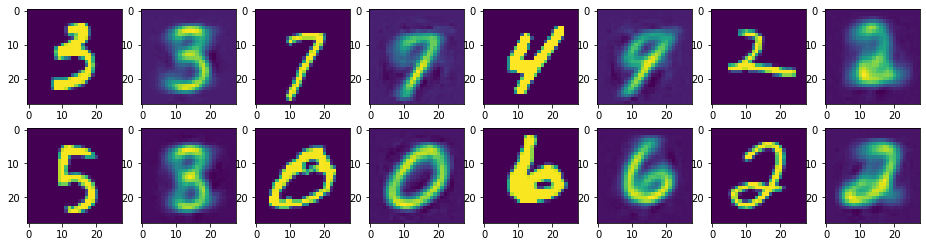

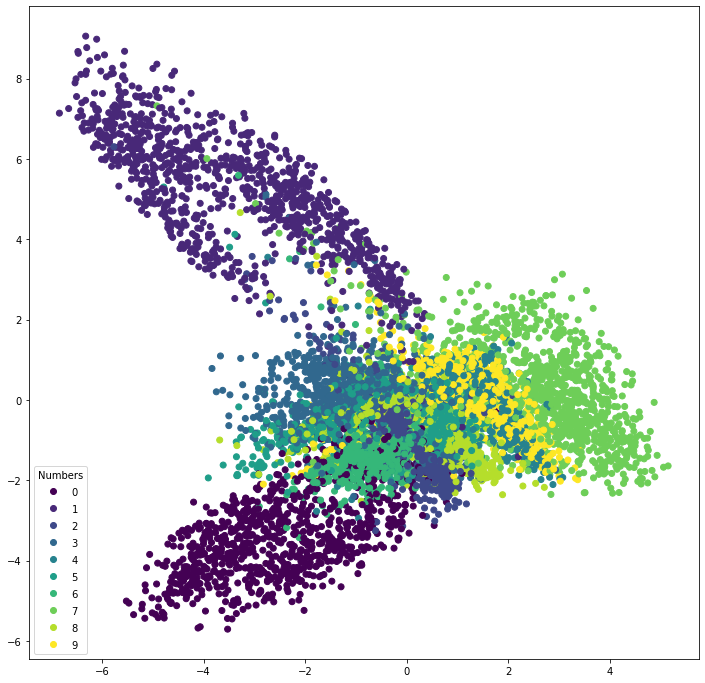

TRAIN | epoch: 25 | loss: 33.355201721191406
TRAIN | epoch: 26 | loss: 33.30820083618164
TRAIN | epoch: 27 | loss: 33.26499938964844
TRAIN | epoch: 28 | loss: 33.21310043334961
TRAIN | epoch: 29 | loss: 33.16059875488281
TRAIN | epoch: 30 | loss: 33.12459945678711
TRAIN | epoch: 31 | loss: 33.07460021972656
TRAIN | epoch: 32 | loss: 33.03519821166992
TRAIN | epoch: 33 | loss: 32.9911994934082
TRAIN | epoch: 34 | loss: 32.965999603271484
TRAIN | epoch: 35 | loss: 32.93130111694336
TRAIN | epoch: 36 | loss: 32.89889907836914
TRAIN | epoch: 37 | loss: 32.84659957885742
TRAIN | epoch: 38 | loss: 32.825801849365234
TRAIN | epoch: 39 | loss: 32.80780029296875
TRAIN | epoch: 40 | loss: 32.77119827270508
TRAIN | epoch: 41 | loss: 32.73509979248047
TRAIN | epoch: 42 | loss: 32.6875
TRAIN | epoch: 43 | loss: 32.677101135253906
TRAIN | epoch: 44 | loss: 32.645198822021484
TRAIN | epoch: 45 | loss: 32.623199462890625
TRAIN | epoch: 46 | loss: 32.58359909057617
TRAIN | epoch: 47 | loss: 32.56560134

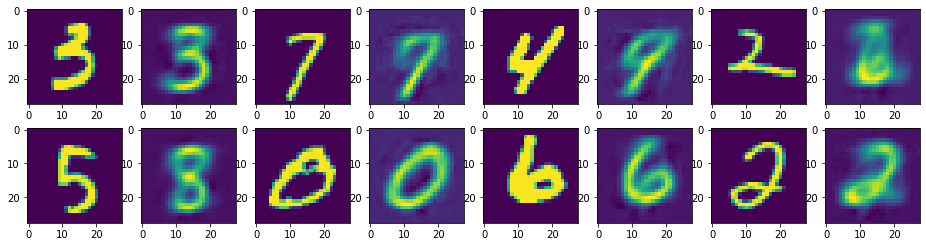

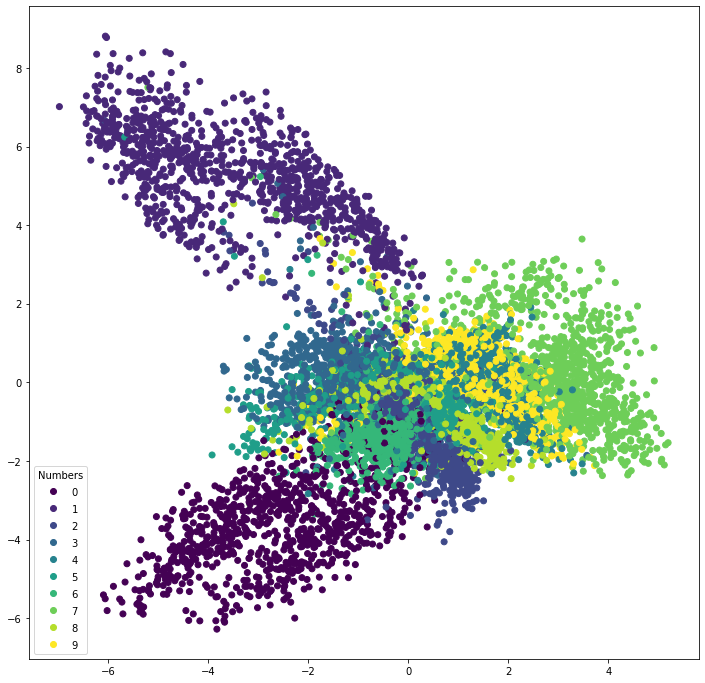

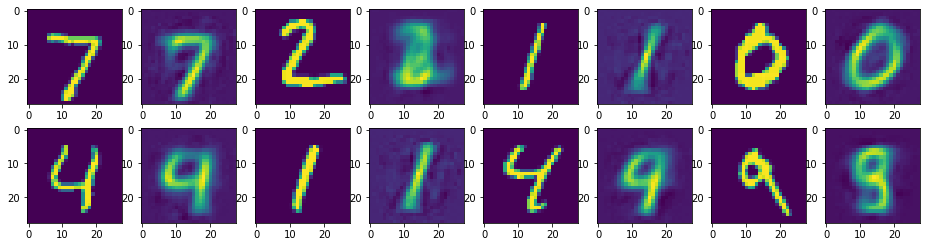

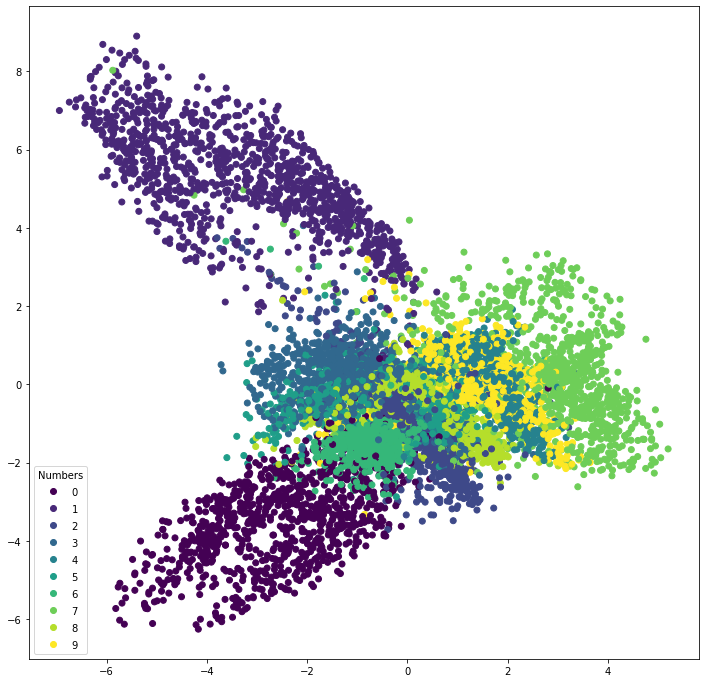

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/loss': 0.04266660660505295}
--------------------------------------------------------------------------------


[{'test/loss': 0.04266660660505295}]

In [238]:
autoencoder = AutoEncoder()

trainer = pl.Trainer(
    num_processes=1,
    #gpus=1,
    #num_nodes=1,
    max_epochs=50,
    min_epochs=None,
    max_steps=None,
    min_steps=None,
    default_root_dir=os.getcwd(),
    callbacks=None,
    checkpoint_callback=False,  # if False, does not store checkpoint
    check_val_every_n_epoch=25,
    num_sanity_val_steps=-1,  # validate before training(full validation set)
    progress_bar_refresh_rate=0,  # do not show tqdm progress bar
)
trainer.fit(autoencoder, train_loader, valid_loader)

trainer.test(autoencoder, test_loader)

### 3.3 How to use callback

- save checkpoints

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.4 K
1 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)


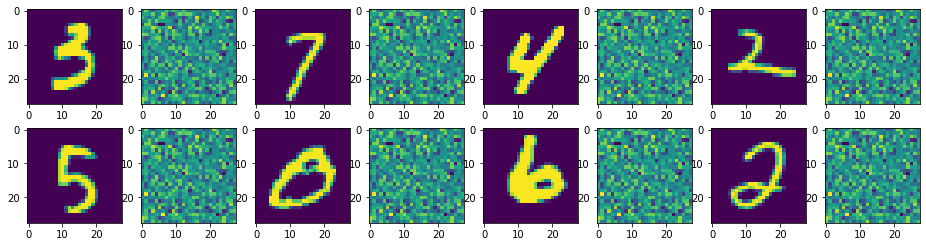

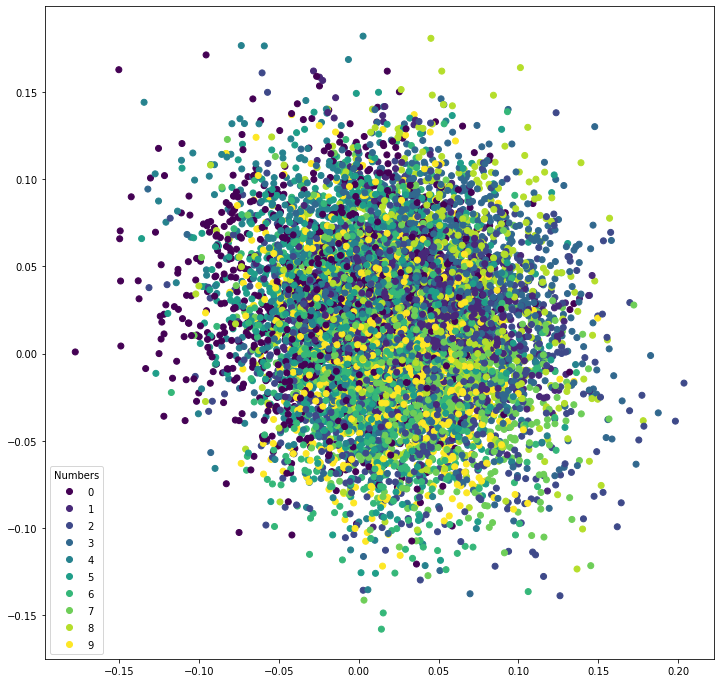

TRAIN | epoch: 0 | loss: 43.14469909667969


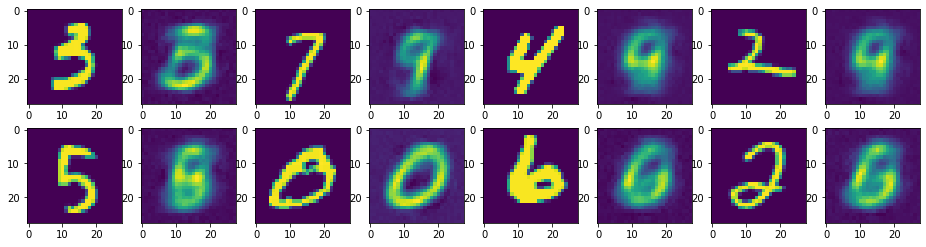

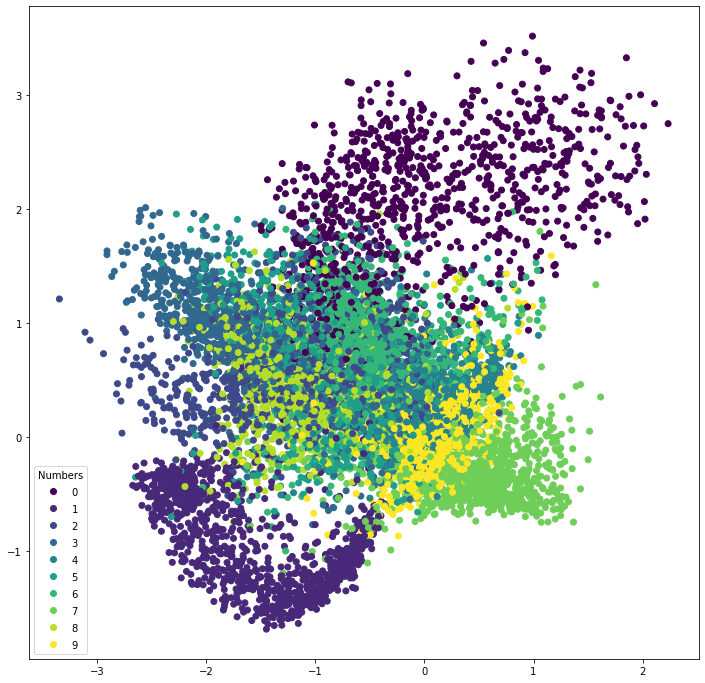

TRAIN | epoch: 1 | loss: 37.75469970703125


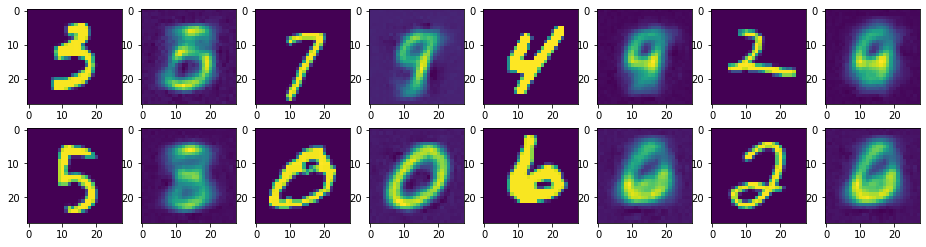

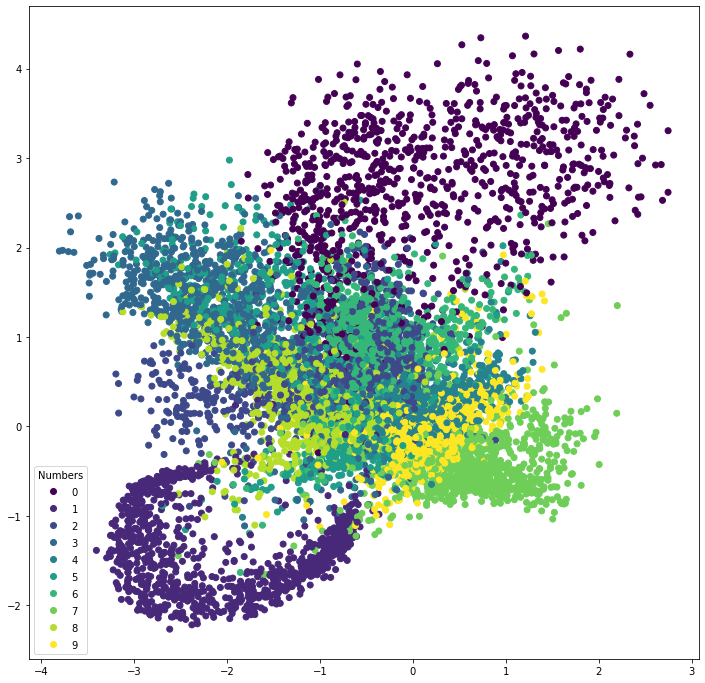

In [239]:
save_dir = "./save"
checkpoint_dir = save_dir + "/checkpoints"

autoencoder = AutoEncoder()

# Define checkpoint callback
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='valid/loss',  # Default None. If None, it store only last one.
    dirpath=checkpoint_dir,  # Directory to save the checkpoint. Checkpoint directory must be empty.
    filename=str(round(time.time())) + '-' + '{epoch:02d}',  # File name of the checkpoint.
    save_top_k=1,  # How many models to save.
    mode='min',
)

# pass callback function
trainer = pl.Trainer(
    max_epochs=2,
    default_root_dir=save_dir,
    callbacks=checkpoint_callback,
    check_val_every_n_epoch=1,
    num_sanity_val_steps=-1,  # validate before training(full validation set)
    progress_bar_refresh_rate=0,  # do not show tqdm progress bar
)
trainer.fit(autoencoder, train_loader, valid_loader)